# Progetto

In [1]:
################### PER COLAB ######################
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/ML/Progetto/')

Mounted at /content/drive


#### Utility gestione memoria

In [2]:
import torch
import gc

# Funzione per verificare l'uso di memoria
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"Memoria allocata: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
        print(f"Memoria riservata: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
        print(f"Memoria totale: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

def clean_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        #torch.cuda.synchronize()
    gc.collect()

clean_gpu_memory()
print_gpu_memory()

## Preprocessing

### Classe per il dataset

In [3]:
import torch
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
import torchvision.transforms as T
import random

# mappatura colore->indice della classe
COLOR2IDX = {
    (255,255,255): 0,  # sfondo (BIANCO)
    (1,88,255):    1,  # cielo (BLU)
    (156,76,30):   2,  # sentiero accidentato (MARRONE)
    (178,176,153): 3,  # sentiero liscio (GRIGIO)
    (128,255,0):   4,  # erba percorribile (VERDE CHIARO)
    (40,80,0):     5,  # vegetazione alta (VERDE SCURO)
    (0,160,0):     6,  # vegetazione bassa non percorribile (VERDE MEDIO)
    (255,0,128):   7,  # pozzanghera (FUCSIA)
    (255,0,0):     8,  # ostacolo (ROSSO)
}

def mask_to_tensor(mask: Image.Image):
    """Converte PIL RGB mask -> LongTensor HxW con valori 0–8."""
    mask = np.array(mask)
    h, w, _ = mask.shape
    out = np.zeros((h, w), dtype=np.int64)
    for rgb, idx in COLOR2IDX.items():
        equality = np.all(mask == rgb, axis=-1)
        out[equality] = idx
    return torch.from_numpy(out)

def get_classes_in_mask(mask: Image.Image):
    """Ritorna le classi (indici) presenti in una maschera PIL."""
    arr = np.array(mask)
    # converto in indici 0–8 già mappati da mask_to_tensor
    flat = mask_to_tensor(mask).numpy().ravel()
    return np.unique(flat)

class JointTransform:
    """
    Trasformazioni congiunte su (img, mask): resize, random crop, flip, color jitter, rotation.
    """
    def __init__(self, resize_size=(288, 544), crop_size=(224,224), flip_prob=0.5, rotation_prob=0.3, max_rotation=5):
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.flip_prob = flip_prob
        self.rotation_prob = rotation_prob
        self.max_rotation = max_rotation
        self.color_jitter = T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1)

    def __call__(self, img, mask):
        # resize
        img = F.resize(img, self.resize_size, interpolation=T.InterpolationMode.BILINEAR)
        mask = F.resize(mask, self.resize_size, interpolation=T.InterpolationMode.NEAREST)
        # crop
        i, j, h, w = T.RandomCrop.get_params(img, output_size=self.crop_size)
        img = F.crop(img, i, j, h, w)
        mask = F.crop(mask, i, j, h, w)
        # flip
        if random.random() < self.flip_prob:
            img = F.hflip(img)
            mask = F.hflip(mask)
        # rotate
        if random.random() < self.rotation_prob:
            angle = random.uniform(-self.max_rotation, self.max_rotation)
            img = F.rotate(img, angle, interpolation=T.InterpolationMode.BILINEAR)
            mask = F.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST)
        # color jitter
        img = self.color_jitter(img)
        return img, mask

class RuralDataset(Dataset):
    def __init__(self, root_dir, ids, joint_transform=None, is_train=True, augmentation_factor=1, rare_class_boost=True):
        self.root = root_dir
        self.ids = ids
        self.joint_transform = joint_transform
        self.is_train = is_train
        self.augmentation_factor = augmentation_factor if is_train else 1
        self.rare_class_boost = rare_class_boost

        # Crea lista espansa degli ID per l'augmentation
        if is_train and augmentation_factor > 1:
            self.expanded_ids = []
            for sid in self.ids:
                # Aggiungi l'originale + versioni augmentate
                for aug_idx in range(augmentation_factor):
                    self.expanded_ids.append((sid, aug_idx))
        else:
            self.expanded_ids = [(sid, 0) for sid in self.ids]

        if is_train and rare_class_boost:
            # Identifica immagini con classi rare
            self.rare_samples = []
            for sid in self.ids:
                mask = Image.open(os.path.join(root_dir, sid, "labels.png")).convert("RGB")
                classes = set(get_classes_in_mask(mask))
                # Se contiene classi 6, 7 o 8, aumenta l'augmentation
                if 6 in classes or 7 in classes or 8 in classes:
                    for _ in range(6):  # 5x più augmentation per classi rare
                        self.rare_samples.append(sid)
            self.expanded_ids.extend([(sid, -1) for sid in self.rare_samples])

    def __len__(self):
        return len(self.expanded_ids)

    def __getitem__(self, idx):
        sid, aug_idx = self.expanded_ids[idx]

        img = Image.open(os.path.join(self.root, sid, "rgb.jpg")).convert("RGB")
        mask = Image.open(os.path.join(self.root, sid, "labels.png")).convert("RGB")

        if self.joint_transform and self.is_train:
            # Se è di training sia trasformazioni che augmentation
            random.seed(hash((sid, aug_idx, idx)) % (2**32)) # un seed diverso per ogni augmentation
            img, mask = self.joint_transform(img, mask)
        else:
            # Se non di training solo trasformazioni, no augmentation
            img = F.resize(img, (288, 544), interpolation=T.InterpolationMode.BILINEAR)
            mask = F.resize(mask, (288, 544), interpolation=T.InterpolationMode.NEAREST)
            img = F.center_crop(img, (224,224))
            mask = F.center_crop(mask, (224,224))

        img_t = F.to_tensor(img)
        img_t = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_t)
        mask_t = mask_to_tensor(mask)
        return img_t, mask_t

> Eseguire solo uno tra Validation set e K-Fold

### Validation Set

#### Senza bilanciamento

In [ ]:
# Impostazioni generali
#root = "/mnt/datasets/esame_ml/train/"   ## PER JUPYTER ##
root = "/content/drive/MyDrive/Colab Notebooks/ML/Progetto/train/" ## PER COLAB ##
all_ids = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
random.seed(202515)
random.shuffle(all_ids)
torch.manual_seed(202515)

# Train/Validation/Test Split
#test_ratio = 0.1
val_ratio = 0.2  # 20% dei dati rimanenti per validation
n_total = len(all_ids)

#ntest = int(n_total * test_ratio)
#nval = int((n_total - ntest) * val_ratio)
nval = int((n_total) * val_ratio)
ntrain = n_total - nval #- ntest

#test_ids = all_ids[:ntest]
#val_ids = all_ids[ntest:ntest + nval]
#train_ids = all_ids[ntest + nval:]
train_ids = all_ids[:ntrain]
val_ids = all_ids[ntrain:]

joint_tf = JointTransform(resize_size=(288, 544), crop_size=(224,224), flip_prob=0.5, rotation_prob=0.3, max_rotation=5)

dataloader_params = {"batch_size": 16, "num_workers": 2, "pin_memory": True} ## PER COLAB ##
#dataloader_params = {"batch_size": 1, "num_workers": 0, "pin_memory": False} ## Leggero

train_ds = RuralDataset(root, train_ids, joint_transform=joint_tf, is_train=True, augmentation_factor=5)
val_ds = RuralDataset(root, val_ids, joint_transform=joint_tf, is_train=False)
#test_ds = RuralDataset(root, test_ids, joint_transform=joint_tf, is_train=False)

train_loader = DataLoader(train_ds, shuffle=True, **dataloader_params)
val_loader = DataLoader(val_ds, shuffle=False, **dataloader_params)
#test_loader = DataLoader(test_ds, shuffle=False, **dataloader_params)

print("=== SUDDIVISIONE DATASET ===")
print(f"Dataset totale: {n_total} campioni")
print(f"Training set: {len(train_ds)} campioni ({len(train_ids)} originali × {5} augmentation)")
print(f"Validation set: {len(val_ds)} campioni")
#print(f"Test set: {len(test_ds)} campioni")

#### Con bilanciamento

In [4]:
from collections import defaultdict
from tqdm import tqdm
import os
import json

def create_class_image_map(ids, root_dir):
    """
    Costruisce due strutture:
     - class_to_ids[c] = set di ids che contengono la classe c
     - id_to_classes[id] = set di classi presenti in id
    """
    class_to_ids = defaultdict(set)
    id_to_classes = {}
    for sid in tqdm(ids, desc="Analisi classi"):
        mask = Image.open(os.path.join(root_dir, sid, "labels.png")).convert("RGB")
        classes = set(get_classes_in_mask(mask))
        id_to_classes[sid] = classes
        for c in classes:
            class_to_ids[c].add(sid)
    return class_to_ids, id_to_classes


def stratified_validation_split(ids, root_dir, val_ratio=0.2, seed=202515, num_classes=9):
    """
    Suddivide la lista di ids in train e validation set cercando di bilanciare
    la presenza di ciascuna classe nel validation set.
    """
    random.seed(seed)
    class_to_ids, id_to_classes = create_class_image_map(ids, root_dir)

    val_ids = set()
    remaining_ids = set(ids)

    # Numero target di campioni per validation
    target_val_size = int(len(ids) * val_ratio)

    # Bilanciamento per classe con controllo della dimensione totale
    for c in range(num_classes):
        if len(val_ids) >= target_val_size:
            break

        # Prendi gli ID che contengono questa classe e non sono ancora in validation
        available_ids = list(class_to_ids[c] & remaining_ids)

        if not available_ids:
            continue

        random.shuffle(available_ids)

        # Calcola quanti campioni aggiungere per questa classe
        # Limita in base alla dimensione target rimanente
        remaining_slots = target_val_size - len(val_ids)
        class_target = max(1, int(len(available_ids) * val_ratio))
        n_to_add = min(class_target, remaining_slots, len(available_ids))

        # Aggiungi i campioni al validation set
        for i in range(n_to_add):
            val_ids.add(available_ids[i])
            remaining_ids.remove(available_ids[i])

    # Se non è stata raggiunta la dimensione target, aggiungo campioni casuali
    if len(val_ids) < target_val_size:
        remaining_list = list(remaining_ids)
        random.shuffle(remaining_list)
        additional_needed = target_val_size - len(val_ids)

        for i in range(min(additional_needed, len(remaining_list))):
            val_ids.add(remaining_list[i])
            remaining_ids.remove(remaining_list[i])

    train_ids = list(remaining_ids)
    val_ids = list(val_ids)

    return train_ids, val_ids

def calculate_class_weights(data_loader, num_classes, method='sqrt_inverse'):
    """
    Calcola i pesi delle classi da usare per la loss pesata.
    Args:
        method (str): Il metodo da usare. Opzioni: 'median_frequency', 'inverse_frequency', 'sqrt_inverse'.
    Returns:
        torch.Tensor: Un tensore di dimensione (num_classes,) contenente i pesi per ogni classe.
    """
    print(f"Inizio calcolo pesi delle classi con metodo '{method}'...")

    # Inizializza un tensore per contare i pixel di ogni classe
    class_counts = torch.zeros(num_classes, dtype=torch.long, device='cpu')

    # Itera su tutto il training set per contare i pixel
    loop = tqdm(data_loader, desc="Conteggio Pixel per Classe", leave=False)
    for _, masks in loop:
        # masks è un batch di maschere, di solito (B, H, W)
        flat_masks = masks.view(-1)
        counts = torch.bincount(flat_masks, minlength=num_classes)
        class_counts += counts.cpu()

    total_pixels = class_counts.sum().item()

    print("Conteggio pixel per classe completato.")
    print(class_counts)

    # Calcolo dei pesi
    if method == 'median_frequency':
        # Frequenza per ogni classe
        frequencies = class_counts.float() / total_pixels
        # Mediana delle frequenze (solo delle classi presenti)
        median_freq = torch.median(frequencies[frequencies > 0])
        # Peso = mediana / frequenza
        weights = median_freq / (frequencies + 1e-6)
        weights = weights.numpy()

    elif method == 'inverse_frequency':
        # Peso = 1 / frequenza
        frequencies = class_counts.float() / total_pixels
        weights = 1.0 / (frequencies + 1e-6)
        weights = weights.numpy()

    elif method == 'sqrt_inverse':
        weights = []
        for count in class_counts:
            if count > 0:
                weight = np.sqrt(total_pixels / (len(class_counts) * int(count)))
                weights.append(weight)
            else:
                weights.append(1.0)
        weights = np.array(weights)  # Converti in numpy array

    else:
        raise ValueError(f"Metodo '{method}' non supportato.")

    # Gestione di classi non presenti nel dataset
    weights[class_counts.numpy() == 0] = 0.0

    # Normalizzazione
    weights = weights / weights.mean()
    weights = np.clip(weights, 0.1, 10.0)

    print("Pesi calcolati:", np.round(weights, 4))

    return weights

# Impostazioni generali
#root = "/mnt/datasets/esame_ml/train/"   ## PER JUPYTER ##
root = "/content/drive/MyDrive/Colab Notebooks/ML/Progetto/train/" ## PER COLAB ##

# --- Logica di caricamento o calcolo ---
output_dir = "/content/drive/MyDrive/Colab Notebooks/ML/Progetto/data_splits/" # directory in cui salvare gli ids e pesi per riproducibilità ed efficienza
train_ids_file = os.path.join(output_dir, "train_ids.json")
val_ids_file = os.path.join(output_dir, "val_ids.json")
weights_file = os.path.join(output_dir, "class_weights.npy")

# Controlla se caricare gli split e pesi o calcolarli
if os.path.exists(train_ids_file) and os.path.exists(val_ids_file) and os.path.exists(weights_file):
    print("Caricamento di train_ids, val_ids e class_weights dai file salvati...")
    with open(train_ids_file, "r") as f:
        train_ids = json.load(f)
    with open(val_ids_file, "r") as f:
        val_ids = json.load(f)
    class_weights = np.load(weights_file)
    print("Dati caricati con successo.")
    print(f"Training set: {len(train_ids)} campioni")
    print(f"Validation set: {len(val_ids)} campioni")
    print(f"Pesi delle classi: {class_weights}")
else:
    print("File non trovati. Calcolo la suddivisione e i pesi da capo...")
    all_ids = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    random.seed(202515)
    random.shuffle(all_ids)
    torch.manual_seed(202515)

    # Suddivisione Train/Validation
    val_ratio = 0.2  # 20% dei dati rimanenti per validation
    n_total = len(all_ids)

    # Creazione del validation set stratificato
    train_ids, val_ids = stratified_validation_split(all_ids, root_dir=root, val_ratio=val_ratio)

    print(f"\nSuddivisione stratificata completata:")
    print(f"Training set: {len(train_ds)} campioni ({len(train_ids)} originali × {augmentation_factor} augmentation)")
    print(f"Validation set: {len(val_ds)} campioni")

    # Calcolo dei pesi delle classi per la loss
    class_weights = calculate_class_weights(train_loader, num_classes=9)

    # Salvataggio per riproducibilità ed efficienza
    os.makedirs(output_dir, exist_ok=True)

    # ID in file JSON
    with open(train_ids_file, "w") as f:
        json.dump(train_ids, f)
    with open(val_ids_file, "w") as f:
        json.dump(val_ids, f)
    print(f"Salvati train_ids e val_ids in '{output_dir}'")

    # Salvo i pesi delle classi usando NumPy
    np.save(weights_file, class_weights)
    print(f"Salvati class_weights in '{output_dir}/class_weights.npy'")


## Crea i DataLoader con i dati caricati o calcolati
joint_tf = JointTransform(resize_size=(288, 544), crop_size=(224,224), flip_prob=0.5, rotation_prob=0.3, max_rotation=10)
augmentation_factor = 5

print("Creazione dei DataLoader...")
train_ds = RuralDataset(root, train_ids, joint_transform=joint_tf, is_train=True, augmentation_factor=augmentation_factor)
val_ds = RuralDataset(root, val_ids, joint_transform=joint_tf, is_train=False)

dataloader_params = {"batch_size": 4, "num_workers": 2, "pin_memory": True} ## PER COLAB ##
#dataloader_params = {"batch_size": 24, "num_workers": 2, "pin_memory": True}

train_loader = DataLoader(train_ds, shuffle=True, **dataloader_params)
val_loader = DataLoader(val_ds, shuffle=False, **dataloader_params)
print("DataLoader creati con successo.")

Caricamento di train_ids, val_ids e class_weights dai file salvati...
Dati caricati con successo.
Training set: 745 campioni
Validation set: 186 campioni
Pesi delle classi: [1.07973756 0.62136161 0.42188264 0.38595776 0.50338378 0.30893419
 0.62893091 3.32143373 1.72837783]


Distribuzione delle classi

In [ ]:
print("\nDistribuzione delle classi nel training set:\n")
_, train_id_to_classes = create_class_image_map(train_ids, root)
class_counts_train = defaultdict(int)
for sid in train_ids:
    for c in train_id_to_classes[sid]:
        class_counts_train[c] += 1

for c in range(9):
    print(f"Classe {c}: {class_counts_train[c]} campioni")

print("\nDistribuzione delle classi nel validation set:\n")
_, val_id_to_classes = create_class_image_map(val_ids, root)
class_counts_val = defaultdict(int)
for sid in val_ids:
    for c in val_id_to_classes[sid]:
        class_counts_val[c] += 1

for c in range(9):
    print(f"Classe {c}: {class_counts_val[c]} campioni")

# print("\nDistribuzione delle classi nel test set:\n")
# _, test_id_to_classes = create_class_image_map(test_ids, root)
# class_counts_test = defaultdict(int)
# for sid in test_ids:
#     for c in test_id_to_classes[sid]:
#         class_counts_test[c] += 1

# for c in range(9):
#     print(f"Classe {c}: {class_counts_test[c]} campioni")


Distribuzione delle classi nel training set:



Analisi classi: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 745/745 [02:07<00:00,  5.86it/s]


Classe 0: 745 campioni
Classe 1: 681 campioni
Classe 2: 416 campioni
Classe 3: 446 campioni
Classe 4: 509 campioni
Classe 5: 737 campioni
Classe 6: 280 campioni
Classe 7: 35 campioni
Classe 8: 135 campioni

Distribuzione delle classi nel validation set:



Analisi classi: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:31<00:00,  5.86it/s]

Classe 0: 186 campioni
Classe 1: 163 campioni
Classe 2: 104 campioni
Classe 3: 103 campioni
Classe 4: 133 campioni
Classe 5: 186 campioni
Classe 6: 75 campioni
Classe 7: 7 campioni
Classe 8: 29 campioni


### K-Fold
>eseguire solo una delle due celle sottostanti



#### Senza bilanciamento

In [ ]:
# Impostazioni generali
#root = "/mnt/datasets/esame_ml/train/"   ## PER JUPYTER ##
root = "/content/drive/MyDrive/Colab Notebooks/ML/Progetto/train/" ## PER COLAB ##
all_ids = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
random.seed(202515)
random.shuffle(all_ids)
torch.manual_seed(202515)

# K-Fold Cross Validation
test_ratio = 0.1
n_total = len(all_ids)
ntest = int(n_total * test_ratio)
test_ids = all_ids[:ntest]
train_val_ids = all_ids[ntest:]

k = 3
n = len(train_val_ids)
fold_size = n // k

train_loaders = []
val_loaders = []
joint_tf = JointTransform(resize_size=(256,512), crop_size=(224,224), flip_prob=0.5, rotation_prob=0.3, max_rotation=15)

dataloader_params = {"batch_size": 8, "num_workers": 2, "pin_memory": True} ## PER COLAB ##
#dataloader_params = {"batch_size": 1, "num_workers": 0, "pin_memory": False} ## Leggero

for fold in range(k):
    start = fold * fold_size
    end = start + fold_size if fold < k-1 else n
    val_ids = train_val_ids[start:end]
    train_ids = train_val_ids[:start] + train_val_ids[end:]

    train_ds = RuralDataset(root, train_ids, joint_transform=joint_tf, is_train=True, augmentation_factor=5)
    val_ds   = RuralDataset(root, val_ids,   joint_transform=joint_tf, is_train=False)

    train_loader = DataLoader(train_ds, shuffle=True, **dataloader_params)
    val_loader   = DataLoader(val_ds, shuffle=False, **dataloader_params)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
print("train_loaders[i], val_loaders[i] contengono i DataLoader per il fold i")

# test set
test_ds = RuralDataset(root, test_ids, joint_transform=joint_tf, is_train=False)
test_loader = DataLoader(test_ds, shuffle=False, **dataloader_params)

print(f"K-Fold su con k={k}")
print(f"Ogni fold contiene: ")
for i in range(k):
    print(f" - Fold {i+1}:")
    print(f"\t{len(train_loaders[i].dataset)} campioni di training")
    print(f"\t{len(val_loaders[i].dataset)} campioni di validation")

print(f"Test su {len(test_ids)} campioni riservati.")

train_loaders[i], val_loaders[i] contengono i DataLoader per il fold i
K-Fold su con k=3
Ogni fold contiene: 
 - Fold 1:
	2795 campioni di training
	279 campioni di validation
 - Fold 2:
	2795 campioni di training
	279 campioni di validation
 - Fold 3:
	2790 campioni di training
	280 campioni di validation
Test su 93 campioni riservati.


#### Con bilanciamento

In [ ]:
from collections import defaultdict

def get_classes_in_mask(mask: Image.Image):
    """Ritorna le classi (indici) presenti in una maschera PIL."""
    arr = np.array(mask)
    # converto in indici 0–8 già mappati da mask_to_tensor
    flat = mask_to_tensor(mask).numpy().ravel()
    return np.unique(flat)

def create_class_image_map(ids, root_dir):
    """
    Costruisce due strutture:
     - class_to_ids[c] = set di ids che contengono la classe c
     - id_to_classes[id] = set di classi presenti in id
    """
    class_to_ids = defaultdict(set)
    id_to_classes = {}
    for sid in tqdm(ids, desc="Analisi classi"):
        mask = Image.open(os.path.join(root_dir, sid, "labels.png")).convert("RGB")
        classes = set(get_classes_in_mask(mask))
        id_to_classes[sid] = classes
        for c in classes:
            class_to_ids[c].add(sid)
    return class_to_ids, id_to_classes


def stratified_kfold_split(ids, root_dir, k=3, seed=202515, num_classes=9):
    """
    Suddivide la lista di ids in k fold cercando di bilanciare la presenza di ciascuna classe.
    Ritorna una lista di k liste di ids per il validation set di ciascun fold.
    """
    random.seed(seed)
    class_to_ids, _ = create_class_image_map(ids, root_dir)
    folds = [list() for _ in range(k)]
    class_counts = [defaultdict(int) for _ in range(k)]

    for c in range(num_classes):
        sid_list = list(class_to_ids[c])
        random.shuffle(sid_list)
        for sid in sid_list:
            # scegli il fold dove la classe c è meno rappresentata
            target = min(range(k), key=lambda f: class_counts[f][c])
            folds[target].append(sid)
            class_counts[target][c] += 1

    # rimuovo eventuali duplicati dovuti a immagini multi-classe
    for i in range(k):
        folds[i] = list(dict.fromkeys(folds[i]))

    return folds

# Impostazioni generali
#root = "/mnt/datasets/esame_ml/train/"   ## PER JUPYTER ##
root = "/content/drive/MyDrive/Colab Notebooks/ML/Progetto/train/" ## PER COLAB ##
all_ids = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
random.seed(202515)
random.shuffle(all_ids)
torch.manual_seed(202515)

# K-Fold Cross Validation
test_ratio = 0.1
n_total = len(all_ids)
ntest = int(n_total * test_ratio)
test_ids = all_ids[:ntest]
train_val_ids = all_ids[ntest:]

k = 3
val_id_folds = stratified_kfold_split(train_val_ids, root_dir=root, k=k)

train_loaders = []
val_loaders = []
joint_tf = JointTransform(resize_size=(256,512), crop_size=(224,224), flip_prob=0.5, rotation_prob=0.3, max_rotation=15)

dataloader_params = {"batch_size": 8, "num_workers": 2, "pin_memory": True} ## PER COLAB ##
#dataloader_params = {"batch_size": 1, "num_workers": 0, "pin_memory": False} ## Leggero

for fold in range(k):
    val_ids = val_id_folds[fold]
    train_ids = [sid for sid in train_val_ids if sid not in val_ids]

    train_ds = RuralDataset(root, train_ids, joint_transform=joint_tf, is_train=True, augmentation_factor=5)
    val_ds   = RuralDataset(root, val_ids,   joint_transform=joint_tf, is_train=False)

    train_loaders.append(DataLoader(train_ds, shuffle=True,  **dataloader_params))
    val_loaders.append(DataLoader(val_ds, shuffle=False, **dataloader_params))

# test set
test_ds = RuralDataset(root, test_ids, joint_transform=joint_tf, is_train=False)
test_loader = DataLoader(test_ds, shuffle=False, **dataloader_params)

print(f"Stratified K-Fold: {k} fold creati con bilanciamento delle classi.")
print(f"Ogni fold contiene: ")
for i in range(k):
    print(f" - Fold {i+1}:")
    print(f"\t{len(train_loaders[i].dataset)} campioni di training")
    print(f"\t{len(val_loaders[i].dataset)} campioni di validation")
print(f"Test su {len(test_ids)} campioni riservati.")

# Verifica distribuzioni delle classi nei fold
print("\nDistribuzione delle classi nei fold:")
for i in range(k):
    print(f"\tFold {i+1}:")
    _, id_to_classes = create_class_image_map(val_id_folds[i], root)
    class_counts = defaultdict(int)
    for sid in val_id_folds[i]:
        for c in id_to_classes[sid]:
            class_counts[c] += 1

    for c in range(9):
        print(f" - \tClasse {c}: {class_counts[c]} campioni")
    print()

### Per visualizzare samples

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
import torchvision.transforms as T

# Inversione normalizzazione corretta
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Mappatura indice->colore
IDX2COLOR = {v: k for k, v in COLOR2IDX.items()}

def visualize_pair(image_t, mask_t, pred_t=None):
    # Denormalizza e converte a PIL
    img = inv_normalize(image_t)
    img = torch.clamp(img, 0, 1)
    img_pil = F.to_pil_image(img)

    # Maschera vera
    mask_np = mask_t.cpu().numpy()
    mask_rgb = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for cls, color in IDX2COLOR.items():
        mask_rgb[mask_np == cls] = color
    mask_pil = Image.fromarray(mask_rgb)

    # Predizione
    if pred_t is not None:
        # controlla se pred_t è numpy o torch tensor
        if isinstance(pred_t, torch.Tensor):
            pred_t = pred_t.cpu().numpy()
        elif isinstance(pred_t, np.ndarray):
            pred_np = pred_t # Use the NumPy array directly

        pred_rgb = np.zeros((pred_np.shape[0], pred_np.shape[1], 3), dtype=np.uint8)
        for cls, color in IDX2COLOR.items():
            pred_rgb[pred_np == cls] = color
        pred_pil = Image.fromarray(pred_rgb)

    # Plot
    cols = 3 if pred_t is not None else 2
    fig, axs = plt.subplots(1, cols, figsize=(5*cols, 5))
    axs[0].imshow(img_pil); axs[0].set_title('Originale'); axs[0].axis('off')
    axs[1].imshow(mask_pil); axs[1].set_title('Ground Truth'); axs[1].axis('off')
    if pred_t is not None:
        axs[2].imshow(pred_pil); axs[2].set_title('Predizione'); axs[2].axis('off')
    plt.show()

In [ ]:
# Prendiamo un batch dal primo dataloader di training
batch = next(iter(train_loaders[0]))
images, masks = batch

print("Dimensione batch: ", len(batch))

# Selezioniamo il primo sample del batch per visualizzarlo
sample_index = 0
img_to_visualize = images[sample_index]
mask_to_visualize = masks[sample_index]

# Visualizziamo la coppia
visualize_pair(img_to_visualize, mask_to_visualize)

# Selezioniamo un altro sample per visualizzarlo (ad esempio il secondo)
sample_index_2 = 1
img_to_visualize_2 = images[sample_index_2]
mask_to_visualize_2 = masks[sample_index_2]

# Visualizziamo la seconda coppia
visualize_pair(img_to_visualize_2, mask_to_visualize_2)

# Puoi visualizzare più coppie semplicemente cambiando l'indice del sample
# Esempio per visualizzare il terzo campione
# sample_index_3 = 2
# img_to_visualize_3 = images[sample_index_3]
# mask_to_visualize_3 = masks[sample_index_3]
# visualize_pair(img_to_visualize_3, mask_to_visualize_3)

KeyboardInterrupt: 

## Architetture

### ResNet18-UNet

In [12]:
from torchvision import models
import torch.nn as nn
from torchvision.models.resnet import resnet18, ResNet18_Weights

class ResNet18_UNet(nn.Module):
    def __init__(self, num_classes=9, pretrained=True, verbose=False):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        resnet = resnet18(weights=weights)

        # Encoder: blocchi da ResNet18
        # per maggiori informazioni: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L81
        self.input_layer = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)      # 64, 112x112
        self.pool = resnet.maxpool                                                   # 64, 56x56
        self.encoder1 = resnet.layer1  # 64, 56x56
        self.encoder2 = resnet.layer2  # 128, 28x28
        self.encoder3 = resnet.layer3  # 256, 14x14
        self.encoder4 = resnet.layer4  # 512, 7x7

        # Decoder: upsampling + conv
        self.upconv5 = self._upsample_block(512, 256)
        self.upconv4 = self._upsample_block(256+256, 128) # le somme sono per le skip connection
        self.upconv3 = self._upsample_block(128+128, 64)
        self.upconv2 = self._upsample_block(64+64, 64)
        self.upconv1 = self._upsample_block(64+64, 32)

        # Final classifier
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1) # shape output (batch_size, 9, 224, 224)

        if verbose:
            self._print_model_info()

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            ##nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), ## PROVARE INVECE DI Upsample+Conv2d
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # ingrandisce l'immagine di 2 volte (scale_factor = 2)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3) # aggiunto droput
        )

    def forward(self, x):
        # encoding
        x1 = self.input_layer(x)     # 64, 112x112
        x2 = self.pool(x1)           # 64, 56x56
        x3 = self.encoder1(x2)       # 64, 56x56
        x4 = self.encoder2(x3)       # 128, 28x28
        x5 = self.encoder3(x4)       # 256, 14x14
        x6 = self.encoder4(x5)       # 512, 7x7

        # decoding
        d4 = self.upconv5(x6)        # 256, 14x14
        d4 = torch.cat([d4, x5], dim=1) # skip connection
        d3 = self.upconv4(d4)        # 128, 28x28
        d3 = torch.cat([d3, x4], dim=1) # skip connection
        d2 = self.upconv3(d3)        # 64, 56x56
        d2 = torch.cat([d2, x3], dim=1) # skip connection
        d1 = self.upconv2(d2)        # 64, 112x112
        d1 = torch.cat([d1, x1], dim=1) # skip connection
        d0 = self.upconv1(d1)        # 32, 224x224

        # classificazione
        out = self.classifier(d0)    # 9, 224x224

        ## predicted_mask = torch.argmax(out, dim=1)  # shape: (B, 224, 224) ##
        return out

    def _print_model_info(self):
        """Stampa informazioni utili sul modello"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        memory_mb = total_params * 4 / (1024 ** 2)

        print(f"\nResNet18-UNet INFO:")
        print(f"   Parametri totali: {total_params:,}")
        print(f"   Parametri trainable: {trainable_params:,}")
        print(f"   Memoria stimata: ~{memory_mb:.1f} MB\n")


### EfficientNetB0-UNet

In [ ]:
from torchvision import models
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetB0_UNet(nn.Module):
    """
    U-Net con EfficientNet-B0 backbone
    """

    def __init__(self, num_classes=9, pretrained=True, verbose=False):
        super().__init__()

        # Carica EfficientNet-B0 backbone
        if pretrained:
            weights = EfficientNet_B0_Weights.DEFAULT
            backbone = efficientnet_b0(weights=weights)
        else:
            backbone = efficientnet_b0(weights=None)

        # Estrai solo le features (senza il classificatore finale)
        backbone = backbone.features

        # EfficientNet-B0 architecture:
        # - Stem: 32 channels
        # - Stage1: 16 channels  (MBConv1, k3x3)
        # - Stage2: 24 channels  (MBConv6, k3x3)
        # - Stage3: 40 channels  (MBConv6, k5x5)
        # - Stage4: 80 channels  (MBConv6, k3x3)
        # - Stage5: 112 channels (MBConv6, k5x5)
        # - Stage6: 192 channels (MBConv6, k5x5)
        # - Stage7: 320 channels (MBConv6, k3x3)

        # Skip connection layers (adattati per EfficientNet-B0)
        self.encoder1 = nn.Sequential(*backbone[:2])   # Stem
        self.encoder2 = nn.Sequential(*backbone[2:3])  # Stage1
        self.encoder3 = nn.Sequential(*backbone[3:4])  # Stage2
        self.encoder4 = nn.Sequential(*backbone[4:6])  # Stage3-4
        self.encoder5 = nn.Sequential(*backbone[6:])   # Stage5-7

        # Decoder U-Net (ispirato alla tua architettura originale)
        self.upconv5 = self._upsample_block(1280, 80)
        self.upconv4 = self._upsample_block(192, 24)
        self.upconv3 = self._upsample_block(64, 16)
        self.upconv2 = self._upsample_block(40, 32)
        self.upconv1 = self._upsample_block(48, 32)

        # Classificatore finale
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

        # Stampa info sul modello
        if verbose:
            self._print_model_info()

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)     # 32, 112x112
        x2 = self.encoder2(x1)    # 16, 112x112
        x3 = self.encoder3(x2)    # 24, 56x56
        x4 = self.encoder4(x3)    # 80, 28x28
        x5 = self.encoder5(x4)    # 1280, 14x14

        # Decoder con skip connections
        d4 = self.upconv5(x5)                    # 80, 28x28
        d4 = torch.cat([d4, x4], dim=1)          # 160, 28x28

        d3 = self.upconv4(d4)                    # 24, 56x56
        d3 = torch.cat([d3, x3], dim=1)          # 48, 56x56

        d2 = self.upconv3(d3)                    # 16, 112x112
        d2 = torch.cat([d2, x2], dim=1)          # 32, 112x112

        d1 = self.upconv2(d2)                    # 32, 224x224
        d1 = torch.cat([d1, x1], dim=1)          # 64, 224x224

        d0 = self.upconv1(d1)                    # 32, 224x224

        # Classificazione finale
        out = self.classifier(d0)                # 9, 224x224

        return out

    def _print_model_info(self):
        """Stampa informazioni utili sul modello"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        memory_mb = total_params * 4 / (1024 ** 2)

        print(f"\nEfficientNetB0-UNet INFO:")
        print(f"   Parametri totali: {total_params:,}")
        print(f"   Parametri trainable: {trainable_params:,}")
        print(f"   Memoria stimata: ~{memory_mb:.1f} MB\n")

### MobileNetV2-UNet

In [ ]:
from torchvision import models
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

class MobileNetV2_UNet(nn.Module):
    """U-Net con backbone MobileNetV2"""

    def __init__(self, num_classes=9, pretrained=True, verbose=False):
        super().__init__()

        if pretrained:
            weights = MobileNet_V2_Weights.DEFAULT
            backbone = mobilenet_v2(weights=weights)
        else:
            backbone = mobilenet_v2(weights=None)

        # Prendo solo i layer che estraggono features
        backbone = backbone.features

        # Layer per skip connections
        self.encoder1 = nn.Sequential(*backbone[:2])   # 16 channels
        self.encoder2 = nn.Sequential(*backbone[2:4])  # 24 channels
        self.encoder3 = nn.Sequential(*backbone[4:7])  # 32 channels
        self.encoder4 = nn.Sequential(*backbone[7:14]) # 96 channels
        self.encoder5 = nn.Sequential(*backbone[14:])  # 1280 channels

        # # Decoder U-Net
        self.upconv5 = self._upsample_block(1280, 64)
        self.upconv4 = self._upsample_block(64+96, 48)
        self.upconv3 = self._upsample_block(48+32, 24)
        self.upconv2 = self._upsample_block(24+24, 16)
        self.upconv1 = self._upsample_block(16+16, 32)

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

        if verbose:
            self._print_model_info()

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            #nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)    # 16, 112x112
        x2 = self.encoder2(x1)   # 24, 56x56
        x3 = self.encoder3(x2)   # 32, 28x28
        x4 = self.encoder4(x3)   # 96, 14x14
        x5 = self.encoder5(x4)   # 320, 7x7

        # Decoder con skip connections
        d4 = self.upconv5(x5)                    # 96, 14x14
        d4 = torch.cat([d4, x4], dim=1)          # 192, 14x14

        d3 = self.upconv4(d4)                    # 32, 28x28
        d3 = torch.cat([d3, x3], dim=1)          # 64, 28x28

        d2 = self.upconv3(d3)                    # 24, 56x56
        d2 = torch.cat([d2, x2], dim=1)          # 48, 56x56

        d1 = self.upconv2(d2)                    # 16, 112x112
        d1 = torch.cat([d1, x1], dim=1)          # 32, 112x112

        d0 = self.upconv1(d1)                    # 32, 224x224

        out = self.classifier(d0)                # 9, 224x224
        return out

    def _print_model_info(self):
        """Stampa informazioni utili sul modello"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        memory_mb = total_params * 4 / (1024 ** 2)

        print(f"\nMobileNetV2-UNet INFO:")
        print(f"   Parametri totali: {total_params:,}")
        print(f"   Parametri trainable: {trainable_params:,}")
        print(f"   Memoria stimata: ~{memory_mb:.1f} MB\n")

### DeepLabV3-MobileNetV3

In [ ]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
import torch.nn as nn

class DeepLabV3_MobileNetV3(nn.Module):
    """DeepLabV3 con backbone MobileNetV3-Large, adattato a N classi."""

    def __init__(self, num_classes=9, pretrained=True, verbose=False):
        super().__init__()

        if pretrained:
            weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
            self.deeplabv3 = deeplabv3_mobilenet_v3_large(weights=weights)
        else:
            self.deeplabv3 = deeplabv3_mobilenet_v3_large(weights=weights)

        # DeepLabV3 utilizza un blocco "classifier" che termina con 256 canali
        # aggiungo un layer che li porta a num_classes per il nostro problema
        self.deeplabv3.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        # "aux_classifier" è un blocco fully connected utilizzato principalemente per training, si può rimuovere
        self.deeplabv3.aux_classifier = None

        if verbose:
            self._print_model_info()

    def forward(self, x):
        # DeepLabV3 restituisce un dict con 'out' (e 'aux' se presente)
        return self.deeplabv3(x)['out']

    def _print_model_info(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        memory_mb = total_params * 4 / (1024 ** 2)
        print(f"\nDeepLabV3_MobileNetV3 INFO:")
        print(f"  Parametri totali    : {total_params:,}")
        print(f"  Parametri trainable : {trainable:,}")
        print(f"  Memoria stimata     : ~{memory_mb:.1f} MB\n")

### Summary

In [13]:
from torchsummary import summary

#model = MobileNetV2_UNet(verbose=False)
#model = EfficientNetB0_UNet(verbose=False)
#model = DeepLabV3_MobileNetV3(verbose=False)
model = ResNet18_UNet(num_classes=9, pretrained=True, verbose=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# congela tutto
for p in model.parameters():
    p.requires_grad = False

# DeepLabV3-MobileNet
# for p in model.deeplabv3.classifier[4].parameters():
#     p.requires_grad = True

# sblocco decoder e classifier
for block in [model.upconv5, model.upconv4, model.upconv3,
                model.upconv2, model.upconv1, model.classifier]:
    for p in block.parameters():
        p.requires_grad = True

model._print_model_info()
print(model)
#summary(model, (3, 224, 224))

print_gpu_memory()
clean_gpu_memory()
torch.cuda.memory_allocated()


ResNet18-UNet INFO:
   Parametri totali: 13,205,961
   Parametri trainable: 13,205,961
   Memoria stimata: ~50.4 MB


ResNet18-UNet INFO:
   Parametri totali: 13,205,961
   Parametri trainable: 2,029,449
   Memoria stimata: ~50.4 MB

ResNet18_UNet(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

0

## Training

### Utilità

#### Early stopping

In [14]:
# Early stopping basato su una metrica generica
class EarlyStopping:
    """
    Early stopping per monitorare una certa metrica.
    """
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = np.inf
        self.counter = 0

    def step(self, score):
        if score < self.best_score - self.min_delta:
            self.best_score = score
            self.counter = 0;
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

#### Metriche

In [7]:
# Metriche
def compute_metrics(outputs, targets, num_classes=9):
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1) # classe predetta per i pixel
        correct = (preds == targets).float() # tensore di uni e zeri in cui 1 indica pixel correttamente classificato
        accuracy = correct.sum() / correct.numel()

        iou_per_class = []
        for cls in range(num_classes):
            pred_inds = preds == cls
            target_inds = targets == cls
            intersection = (pred_inds & target_inds).sum().item()
            union = (pred_inds | target_inds).sum().item()
            if union == 0:
                iou_per_class.append(float('nan'))
            else:
                iou_per_class.append(intersection / union)

    return accuracy.item(), iou_per_class

def compute_accuracy(preds, targets):
    """Calcola accuratezza"""
    with torch.no_grad():
        correct = (preds == targets).float() # tensore di uni e zeri in cui 1 indica pixel correttamente classificato
        accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def compute_iou_aggregated(all_preds, all_targets, num_classes=9):
    """Calcola IoU su tutti i dati aggregati per evitare problemi con NaN"""
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = all_preds == cls
        target_inds = all_targets == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)

    return iou_per_class


def compute_class_weights(class_counts, total_pixels, method='inverse_freq'):
    """Calcola pesi per le classi basati sulla loro frequenza"""
    num_classes = len(class_counts)

    if method == 'inverse_freq':
        # Peso inversamente proporzionale alla frequenza
        weights = []
        for cls in range(num_classes):
            freq = class_counts[cls] / total_pixels
            if freq > 0:
                weights.append(1.0 / freq)
            else:
                weights.append(1.0)  # Peso default per classi assenti

        # Normalizza i pesi
        weights = np.array(weights)
        weights = weights / weights.mean()

    elif method == 'balanced':
        # Bilanciamento standard sklearn-style
        weights = []
        for cls in range(num_classes):
            if class_counts[cls] > 0:
                weight = total_pixels / (num_classes * class_counts[cls])
                weights.append(weight)
            else:
                weights.append(1.0)
        weights = np.array(weights)

    return torch.FloatTensor(weights)

IoU Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF # Import functional module for softmax etc.
import numpy as np

class IoULoss(nn.Module):
    """
    Implementazione della IoU Loss per segmentazione semantica
    IoU = intersection / union
    """
    def __init__(self, num_classes, smooth=1e-6, iou_weights=None):
        super(IoULoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

        if iou_weights is not None:
            if iou_weights.shape[0] != num_classes:
                raise ValueError(f"iou_weights deve avere dimensione {num_classes}, ma ha dimensione {iou_weights.shape[0]}.")
            else:
                self.iou_weights = iou_weights
        else:
            self.iou_weights = None

    def forward(self, logits, targets):
        """
        logits: Output raw del modello (B, C, H, W) dove C è il numero di classi
        targets: Maschere di ground truth (B, H, W) con valori da 0 a C-1
        """
        # Softmax per ottenere le probabilità
        # Per la IoU come Loss viene utilizzata la probabilità per i calcoli e compatibilità
        probs = nnF.softmax(logits, dim=1)

        # Target in formato one-hot
        targets_one_hot = nnF.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        # Calcola intersection e union per ogni classe
        dims = (2, 3)  # Dimensioni spaziali (H, W)
        intersection = torch.sum(probs * targets_one_hot, dims)
        union = torch.sum(probs + targets_one_hot - probs * targets_one_hot, dims)

        # IoU per ogni classe in ogni campione del batch
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Applica i pesi se forniti
        if self.iou_weights is not None:
            # Espande i pesi per allinearsi con la dimensione del batch: (1, C)
            # Poi moltiplica per iou: (B, C) * (1, C) -> (B, C)
            weighted_iou = iou * self.iou_weights.unsqueeze(0)
            iou_loss = 1 - weighted_iou.mean() # Media pesata su batch e classi (1 - IoU per minimizzare)
        else:
            # Se non ci sono pesi specifici, calcola la media semplice
            iou_loss = 1 - iou.mean()

        return iou_loss

class IoUCELoss(nn.Module):
    """
    Loss combinata: IoU Loss + Cross Entropy Loss
    Args:
        alpha: alpha * IoU Loss + (1 - alpha) * Cross Entropy Loss
        ce_weights: Pesi delle classi nella cross entropy loss
    """
    def __init__(self, num_classes, alpha=0.5, ce_weights=None, iou_weights=None, smooth=1e-6):
        super(IoUCELoss, self).__init__()
        self.alpha = alpha
        self.iou_loss = IoULoss(num_classes=num_classes, smooth=smooth, iou_weights=iou_weights)
        self.ce_loss = nn.CrossEntropyLoss(weight=ce_weights)

    def forward(self, logits, targets):
        iou_loss = self.iou_loss(logits, targets)
        ce_loss = self.ce_loss(logits, targets)

        # Loss combinata
        combined_loss = self.alpha * iou_loss + (1 - self.alpha) * ce_loss
        return combined_loss

Dice Loss
$ 1-2\cdot\frac{|Pred\cap Target|}{|Pred|+|Target|}$

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import numpy as np

class DiceLoss(nn.Module):
    """
    Implementazione della Dice Loss
    - Disce score = 2*intersection/union
    """
    def __init__(self, num_classes, smooth=1e-6, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        """
        logits: Output raw del modello (B, C, H, W) dove C è il numero di classi.
        targets: Maschere di ground truth (B, H, W) con valori da 0 a C-1.
        """
        # Softmax per ottenere le probabilità
        probs = nnF.softmax(logits, dim=1)

        # Target in formato one-hot
        # Shape: (B, H, W) -> (B, C, H, W)
        targets_one_hot = nnF.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2)

        # Calcola l'intersezione e le somme
        dims = (2, 3) # Dimensioni spaziali (H, W)
        intersection = torch.sum(probs * targets_one_hot, dims)
        union = torch.sum(probs + targets_one_hot, dims)

        # Dice score per ogni classe in ogni campione del batch
        # Disce score = 2*intersection/union
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

        # La loss è 1 - Dice Score, perché vogliamo massimizzare lo score (e quindi minimizzare la loss)
        dice_loss = 1 - dice_score.mean()

        return dice_loss

Focal Loss

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import numpy as np

class FocalLoss(nn.Module):
    """
    Focal Loss per gestire classi sbilanciate
    Utile considerando che alcune classi (es. pozzanghera) potrebbero essere rare
    """
    def __init__(self, num_classes, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes
        if alpha is not None and not isinstance(alpha, torch.Tensor):
            self.alpha = torch.tensor(alpha)
        else:
            self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nnF.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

Focal Loss + Dice Loss

In [15]:
class FocalDiceLoss(nn.Module):
    """
    Combinazione di Focal Loss e Dice Loss.
    """
    def __init__(self, num_classes, alpha=None, gamma=2.0, smooth=1e-6, focal_weight=1.0, dice_weight=1.0):
        """
        Args:
            num_classes (int): Numero di classi di segmentazione.
            alpha (torch.Tensor, optional): Pesi per classe per la Focal Loss.
            gamma (float, optional): Esponente di focusing per la Focal Loss. Default: 2.0.
            smooth (float, optional): Valore di smoothing per la Dice Loss. Default: 1e-6.
            focal_weight (float, optional): Peso da dare alla componente Focal Loss. Default: 1.0.
            dice_weight (float, optional): Peso da dare alla componente Dice Loss. Default: 1.0.
        """
        super(FocalDiceLoss, self).__init__()
        self.focal_loss = FocalLoss(num_classes=num_classes, alpha=alpha, gamma=gamma)
        self.dice_loss = DiceLoss(num_classes=num_classes, smooth=smooth)
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        focal = self.focal_loss(logits, targets)
        dice = self.dice_loss(logits, targets)

        # Loss combinata e pesata
        total_loss = self.focal_weight * focal + self.dice_weight * dice

        return total_loss

### Training procedure

Codice per tracking con tensorboard

In [ ]:
import os
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

def start_tensorboard(path_to_logs="/runs"):
  writer = SummaryWriter(path_to_logs)

  # run tensorboard in background
  ! killall tensorboard
  %reload_ext tensorboard
  %tensorboard --logdir ./runs --reload_interval 1

  notebook.list() # View open TensorBoard instances

  return writer

In [ ]:
#!rm -R runs/

#### Con Validation Set

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Costanti di utilità
TOTAL_EPOCHS = 100
WARMUP_EPOCHS = TOTAL_EPOCHS * 0.20
FINETUNE_EPOCHS = TOTAL_EPOCHS * 0.50

# PHASE2_EPOCH = int(TOTAL_EPOCHS * 0.25)
# PHASE3_EPOCH = int(TOTAL_EPOCHS * 0.50)
LR = 1e-3
LR_FINETUNE = 1e-4
# LR_PHASE1 = 5e-4
# LR_PHASE2 = 2e-4
# LR_PHASE3 = 5e-5
LOSS_CLASS_WEIGHTS = torch.from_numpy(class_weights).float().to(device)
PATIENCE = 25
# PATIENCE_PHASE1 = 12
# PATIENCE_PHASE2 = 18
# PATIENCE_PHASE3 = 25

# Verifica memoria disponibile
clean_gpu_memory()
print_gpu_memory()

# Training
clean_gpu_memory()
# Crea modello
model = ResNet18_UNet(num_classes=9, pretrained=True, verbose=True)
#model = DeepLabV3_MobileNetV3(num_classes=9, pretrained=True, verbose=True)
try:
    # Verifica numero parametri
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parametri totali del modello: {total_params:,}")

    # Sposta su GPU con controllo memoria
    clean_gpu_memory()
    model = model.cuda()
    print("Modello spostato su GPU con successo")
    print_gpu_memory()
except RuntimeError as e:
    print(f"ERRORE nel caricamento del modello: {e}")
    print("Provo con CPU...")
    model = model.to(device)

# congela tutto
for p in model.parameters():
    p.requires_grad = False
# sblocco decoder e classifier
for block in [model.upconv5, model.upconv4, model.upconv3,
              model.upconv2, model.upconv1, model.classifier]:
    for p in block.parameters():
        p.requires_grad = True

# # DeepLabV3-MobileNet
# # FASE 1: Solo classifier
# # for p in model.deeplabv3.classifier[4].parameters():
# #     p.requires_grad = True
# for p in model.deeplabv3.classifier.parameters():
#     p.requires_grad = True

# for block in list(model.deeplabv3.backbone.values())[-2:]: # values() perché deeplabv3.backbone è un dict (ModuleDict specializzato per contenere moduli PyTorch)
#     for param in block.parameters():
#         param.requires_grad = True

# Conta parametri trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n-- sbloccati decoder e classifier - Parametri trainable: {trainable_params:,} --\n")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-3)
# optimizer = optim.AdamW([
#     {'params': classifier_params, 'lr': LR_PHASE1, 'weight_decay': 1e-4},
#     {'params': backbone_params, 'lr': LR_PHASE1 * 0.1, 'weight_decay': 5e-4}
# ])
#criterion = IoUCELoss(num_classes=9, alpha=0.7, ce_weights=LOSS_CLASS_WEIGHTS, iou_weights=LOSS_CLASS_WEIGHTS)
criterion = FocalDiceLoss(num_classes=9, alpha=LOSS_CLASS_WEIGHTS, gamma=2.0, focal_weight=1.0, dice_weight=1.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-6)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=1e-4)

# Tracking tensorboard
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
architecture_name = model.__class__.__name__
path_to_logs = f'runs/{architecture_name}/val_set_{timestamp}'
#start_tensorboard(path_to_logs) ## COMMENTARE SE IN JUPYTER ##
writer = SummaryWriter(log_dir=path_to_logs)
print(f"-- Logging su {path_to_logs} --")

# Per salvataggio
#best_val_loss = np.inf
best_val_miou = 0.0
for epoch in range(1, TOTAL_EPOCHS+1):
    # Fase di fine tuning
    if epoch == WARMUP_EPOCHS + 1:
        # attivo tutti i layers
        for p in model.parameters():
            p.requires_grad = True
        # Optimizer per usare lr differenziati per layer
        optimizer = optim.AdamW([
            {'params': model.classifier.parameters(), 'lr': LR_FINETUNE},
            {'params': model.upconv1.parameters(), 'lr': LR_FINETUNE},
            {'params': model.upconv2.parameters(), 'lr': LR_FINETUNE},
            {'params': model.upconv3.parameters(), 'lr': LR_FINETUNE},
            {'params': model.upconv4.parameters(), 'lr': LR_FINETUNE},
            {'params': model.upconv5.parameters(), 'lr': LR_FINETUNE},
            {'params': model.encoder4.parameters(), 'lr': LR_FINETUNE * 0.5},
            {'params': model.encoder3.parameters(), 'lr': LR_FINETUNE * 0.2},
            {'params': model.encoder2.parameters(), 'lr': LR_FINETUNE * 0.1},
            {'params': model.encoder1.parameters(), 'lr': LR_FINETUNE * 0.05},
        ], weight_decay=5e-4)
    # fine-tuning graduale
    # dopo WARMUP_EPOCHS sblocca encoder4
    # Poi ogni step epoche sblocca un altro blocco
    # step = (FINETUNE_EPOCHS // 4)
    # if epoch == WARMUP_EPOCHS + 1:
    #     for p in model.encoder4.parameters():
    #         p.requires_grad = True
    #     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #     print(f"\n-- encoder4 sbloccato - Parametri Trainable: {trainable_params:,}\n")
    #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    # elif epoch == WARMUP_EPOCHS + 1 + step:
    #     for p in model.encoder3.parameters():
    #         p.requires_grad = True
    #     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #     print(f"\n-- encoder4 sbloccato - Parametri Trainable: {trainable_params:,}\n")
    #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    # elif epoch == WARMUP_EPOCHS + 1 + 2*step:
    #     for p in model.encoder2.parameters():
    #         p.requires_grad = True
    #     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #     print(f"\n-- encoder4 sbloccato - Parametri Trainable: {trainable_params:,}\n")
    #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    # elif epoch == WARMUP_EPOCHS + 1 + 3*step:
    #     for p in model.encoder1.parameters():
    #         p.requires_grad = True
    #     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #     print(f"\n-- encoder4 sbloccato - Parametri Trainable: {trainable_params:,}\n")
    #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


    # ==== Training ====
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    # Liste per accumulare tutte le predizioni e target
    all_train_preds = []
    all_train_targets = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", ncols=120)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0) # pesata per dimensione del batch perché l'ultimo batch sarà più piccolo

        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            accuracy = compute_accuracy(preds, masks)
            train_acc += accuracy * imgs.size(0)

            # Accumula predizioni e target per calcolo IoU finale
            all_train_preds.append(preds.cpu())
            all_train_targets.append(masks.cpu())

        # Mostra learning rates attivi
        lrs = [group['lr'] for group in optimizer.param_groups]
        loop.set_postfix(loss=loss.item(), lr_max=max(lrs), lr_min=min(lrs))


    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)
    # Calcolo IoU aggregato per training
    all_train_preds = torch.cat(all_train_preds)
    all_train_targets = torch.cat(all_train_targets)
    train_iou = compute_iou_aggregated(all_train_preds, all_train_targets, num_classes=9)
    train_mean_iou = np.nanmean(train_iou)  # nanmean per gestire NaN

    # ==== Validation ====
    model.eval()
    val_loss = 0
    val_acc = 0
    # Liste per accumulare tutte le predizioni e target di validation
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", ncols=120)
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1)
            accuracy = compute_accuracy(preds, masks)
            val_acc += accuracy * imgs.size(0)

            # Accumula predizioni e target per calcolo IoU finale
            all_val_preds.append(preds.cpu())
            all_val_targets.append(masks.cpu())

            loop.set_postfix(loss=loss.item(), acc=accuracy)

    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)
    # Calcola IoU aggregato per validation
    all_val_preds = torch.cat(all_val_preds)
    all_val_targets = torch.cat(all_val_targets)
    val_iou = compute_iou_aggregated(all_val_preds, all_val_targets, num_classes=9)
    val_mean_iou = np.nanmean(val_iou)  # usa nanmean per gestire NaN

    scheduler.step(val_loss)            # aggiorna learning rate
    stop = early_stopper.step(val_loss) # verifica early stopping

    # === Logging ===
    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
    writer.add_scalars('Mean IoU', {'train': train_mean_iou, 'val': val_mean_iou}, epoch)
    for cls in range(9):
        if not (np.isnan(train_iou[cls]) and np.isnan(val_iou[cls])):
            writer.add_scalars(f'IoU_Class_{cls}', {
                'train': train_iou[cls] if not np.isnan(train_iou[cls]) else 0,
                'val': val_iou[cls] if not np.isnan(val_iou[cls]) else 0
            }, epoch)
    writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train mIoU: {train_mean_iou:.4f}, Val mIoU: {val_mean_iou:.4f}")
    print(f"Learning rates: {[f'{lr:.2e}' for lr in [group['lr'] for group in optimizer.param_groups]]}")
    print(f"Train IoU per classe: {np.round(train_iou, 4)}")
    print(f"Val   IoU per classe: {np.round(val_iou, 4)}")

    # Per salvare il modello migliore
    if val_mean_iou > best_val_miou:
        best_val_miou = val_mean_iou
        os.makedirs(f"models/{architecture_name}/", exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, f"models/{architecture_name}/best_model_valset_{timestamp}.pth")
        print(f"NUOVO MIGLIOR MODELLO! mIoU: {val_mean_iou:.4f}")
        print(f"   Epoca: {epoch}")
        print(f"   mIoU: {val_mean_iou:.4f}")
        print(f"   Loss: {val_loss:.4f}")

    # Early stopping
    if stop:
        print(f"Early stopping alla epoca {epoch}")
        break

    # Pulizia memoria alla fine di ogni epoca
    clean_gpu_memory()

writer.close()
# Pulizia finale
clean_gpu_memory()

print('Training completato')


ResNet18-UNet INFO:
   Parametri totali: 13,205,961
   Parametri trainable: 13,205,961
   Memoria stimata: ~50.4 MB

Parametri totali del modello: 13,205,961
ERRORE nel caricamento del modello: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Provo con CPU...

-- sbloccati decoder e classifier - Parametri trainable: 2,029,449 --

-- Logging su runs/ResNet18_UNet/val_set_2025-06-26_16-52-24 --


Epoch 1 [Train]:  18%|███▉                  | 268/1499 [16:50<1:19:21,  3.87s/it, loss=1.04, lr_max=0.001, lr_min=0.001]

#### Con K-Fold

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

WARMUP_EPOCHS = 5
FINETUNE_EPOCHS = 20
TOTAL_EPOCHS = WARMUP_EPOCHS + FINETUNE_EPOCHS
LR_WARMUP = 1e-4
LR_FINETUNE = 1e-5

start_tensorboard()

# Verifica memoria disponibile
clean_gpu_memory()
print_gpu_memory()

# K-Fold Training
for fold in range(k):

    clean_gpu_memory()

    train_loader, val_loader = train_loaders[fold], val_loaders[fold]

    # Crea modello
    try:
        #model = MobileNetV2_UNet(num_classes=9, pretrained=True, verbose=True)
        model = DeepLabV3_MobileNetV3(num_classes=9, pretrained=True, verbose=True)

        # Verifica numero parametri
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Parametri totali del modello: {total_params:,}")

        # Sposta su GPU con controllo memoria
        clean_gpu_memory()
        model = model.to(device)
        print("Modello spostato su GPU con successo")
        print_gpu_memory()
    except RuntimeError as e:
        print(f"ERRORE nel caricamento del modello: {e}")
        print("Provo con CPU...")
        device = torch.device('cpu')
        model = model.to(device)

    # congela tutto
    for p in model.parameters():
        p.requires_grad = False
    # sblocco decoder e classifier
    # for block in [model.upconv5, model.upconv4, model.upconv3,
    #               model.upconv2, model.upconv1, model.classifier]:
    #     for p in block.parameters():
    #         p.requires_grad = True
    # DeepLabV3-MobileNet
    for p in model.model.classifier[4].parameters():
        p.requires_grad = True

    # Conta parametri trainable
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parametri trainable: {trainable_params:,}")

    # optimizer per il solo i parametri warmup, requires_grad = True
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_WARMUP)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    #early_stopper = EarlyStopping(patience=7, min_delta=1e-4)
    early_stopper = EarlyStoppingmIoU(patience=7, min_delta=1e-4)

    timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    writer = SummaryWriter(log_dir=f'runs/fold_{fold+1}_{timestamp}')

    # Per salvataggio
    #best_val_loss = np.inf
    best_val_miou = 0.0
    for epoch in range(1, TOTAL_EPOCHS+1):
        # fine-tuning graduale
        # dopo WARMUP_EPOCHS sblocca encoder4
        # Poi ogni step epoche sblocca un altro blocco
        # step = (FINETUNE_EPOCHS // 4)
        # if epoch == WARMUP_EPOCHS + 1:
        #     for p in model.encoder4.parameters(): p.requires_grad = True
        #     print(f"[Fold {fold+1}] encoder4 sbloccato, lr -> {LR_FINETUNE}")
        #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
        #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        # elif epoch == WARMUP_EPOCHS + 1 + step:
        #     for p in model.encoder3.parameters(): p.requires_grad = True
        #     print(f"[Fold {fold+1}] encoder3 sbloccato")
        #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
        #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        # elif epoch == WARMUP_EPOCHS + 1 + 2*step:
        #     for p in model.encoder2.parameters(): p.requires_grad = True
        #     print(f"[Fold {fold+1}] encoder2 sbloccato")
        #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
        #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
        # elif epoch == WARMUP_EPOCHS + 1 + 3*step:
        #     for p in model.encoder1.parameters(): p.requires_grad = True
        #     print(f"[Fold {fold+1}] encoder1 sbloccato")
        #     optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FINETUNE)
        #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        # Training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_iou = np.zeros(9)
        train_mean_iou = 0.0

        loop = tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch} [Train]")
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            acc, iou_list = compute_metrics(outputs, masks, num_classes=9)
            train_acc += acc * imgs.size(0)
            train_iou += np.array(iou_list) * imgs.size(0)
            loop.set_postfix(loss=loss.item(), acc=acc, mIoU=np.mean(train_iou), lr=optimizer.param_groups[0]['lr'])
        train_loss /= len(train_loader.dataset)
        train_acc  /= len(train_loader.dataset)
        train_iou  /= len(train_loader.dataset)
        train_mean_iou = np.mean(train_iou)

        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        val_iou = np.zeros(9)
        val_mean_iou = 0.0

        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Fold {fold+1} | Epoch {epoch} [Val]", leave=False)
            for imgs, masks in loop:
                imgs, masks = imgs.to(device), masks.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * imgs.size(0)
                acc, iou_list = compute_metrics(outputs, masks, num_classes=9)
                val_acc += acc * imgs.size(0)
                val_iou += np.array(iou_list) * imgs.size(0)
                loop.set_postfix(loss=loss.item(), acc=acc, mIoU=np.mean(val_iou))
        val_loss /= len(val_loader.dataset)
        val_acc  /= len(val_loader.dataset)
        val_iou  /= len(val_loader.dataset)
        val_mean_iou = np.mean(val_iou)

        scheduler.step(val_loss) # aggiorna learning rate
        stop = early_stopper.step(val_loss) # verifica early stopping

        # Logging
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        writer.add_scalars('Mean IoU', {'train': train_mean_iou, 'val': val_mean_iou}, epoch)
        for cls in range(9):
            writer.add_scalars(f'IoU_Class_{cls}', {'train': train_iou[cls], 'val': val_iou[cls]}, epoch)
        writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)

        print(f"Fold {fold+1} Epoch {epoch}: Train Loss {train_loss:.4f}  Val Loss {val_loss:.4f}  Train Acc {train_acc:.4f}  Val Acc {val_acc:.4f}  Train mIoU {train_mean_iou:.4f}  Val mIoU {val_mean_iou:.4f}")
        print("Train IoU:", np.round(train_iou, 4), "Media: ", np.round(np.mean(train_iou), 4))
        print("Val   IoU:", np.round(val_iou, 4), "Media: ", np.round(np.mean(val_iou), 4))

        # Per salvare il modello migliore
        if val_mean_iou > best_val_miou:
            best_val_miou = val_mean_iou
            os.makedirs('models', exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, f'models/best_model_fold{fold+1}_{timestamp}.pth')
            print(f"NUOVO MIGLIOR MODELLO fold {fold+1}!")
            print(f"   Epoca: {epoch}")
            print(f"   mIoU: {val_mean_iou:.4f}")
            print(f"   Loss: {val_loss:.4f}")

        # Early stopping
        if stop:
            print(f"Early stopping alla epoca {epoch}")
            break

        # Pulizia memoria alla fine di ogni epoca
        clean_gpu_memory()

    writer.close()
    # Pulizia finale del fold
    del model, optimizer, scheduler, early_stopper
    clean_gpu_memory()

print('Training completato per tutti i fold')

## Testing

### Funzione `predict`

In [ ]:
def predict(model, X):
    model_device = next(model.parameters()).device

    # Preprocessing
    if X.ndim == 3:
        X = X[None, ...]  # (1,H,W,3) aggiunge il batch dimension per gestire anche singole immagini
    # trasforma in tensor (B,3,H,W), float [0,1]
    X_tensor = torch.from_numpy(X).permute(0,3,1,2).float() / 255.0
    # normalizzazione ImageNet
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None] #trasforma il vettore delle medie/deviazioni standard in (channels, 1, 1)
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    X_tensor = (X_tensor - mean) / std

    X_tensor = X_tensor.to(model_device)

    # Forward
    with torch.no_grad():
        logits = model(X_tensor)            # (B,9,H,W)
        preds  = logits.argmax(dim=1)       # (B,H,W)

    preds = preds.cpu().numpy().astype(np.uint8)

    # Se batch di 1, restituisci (H,W)
    if preds.shape[0] == 1:
        return preds[0]
    return preds

### Testing con visualizzazione

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepLabV3_MobileNetV3(num_classes=9, pretrained=True)
# Dictionary salvato che contiene tutto
checkpoint = torch.load(f'models/models/{architecture_name}/best_model_valset_{timestamp}.pth')
# Carico il modello salvato
# strict=False perché sono stati salvati solo i parametri addestrati
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

model.to(device)

In [ ]:
# Test sul test set usando predict
@torch.no_grad()
def test_with_predict(model, loader, device):
    model.eval()
    total_acc, total_iou, total_n = 0.0, np.zeros(len(COLOR2IDX)), 0
    for imgs, masks in loader:
        bs = imgs.size(0)
        for i in range(bs):
            img_np = (imgs[i].cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
            pred = predict(model, img_np)
            # metrica
            out_logits = model(imgs[i:i+1].to(device))
            acc, iou = compute_metrics(out_logits, masks[i:i+1].to(device))
            total_acc += acc; total_iou += np.array(iou); total_n += 1
    return total_acc/total_n, total_iou/total_n

acc, iou_scores = test_with_predict(model, test_loader, device)
print(f"Test Accuracy: {acc:.4f}")
print("Test IoU per classe:", np.round(iou_scores,4))

# Visualizza alcuni campioni random
for _ in range(5):
    idx = random.randrange(len(test_ds))
    img_t, mask_t = test_ds[idx]
    img_np = (img_t.permute(1,2,0).numpy()*255).astype(np.uint8)
    pred_np = predict(model, img_np)
    visualize_pair(img_t, mask_t, pred_np)


Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]



=== RISULTATI TEST ===
Test Accuracy: 0.4165
Test Mean IoU: 0.1529
Test IoU per classe: [0.0802 0.3783 0.1305 0.2612 0.089  0.4276 0.0093 0.     0.    ]

=== VISUALIZZAZIONE CAMPIONI ===
Campione 1:


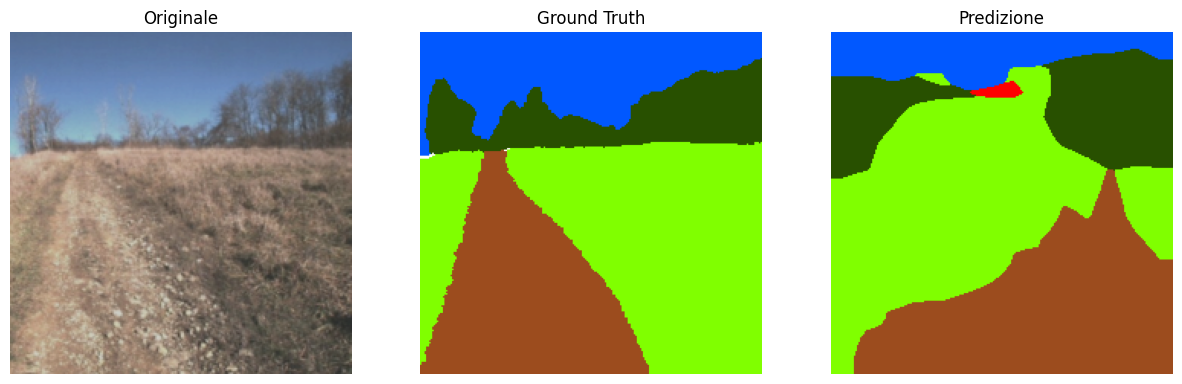

Campione 2:


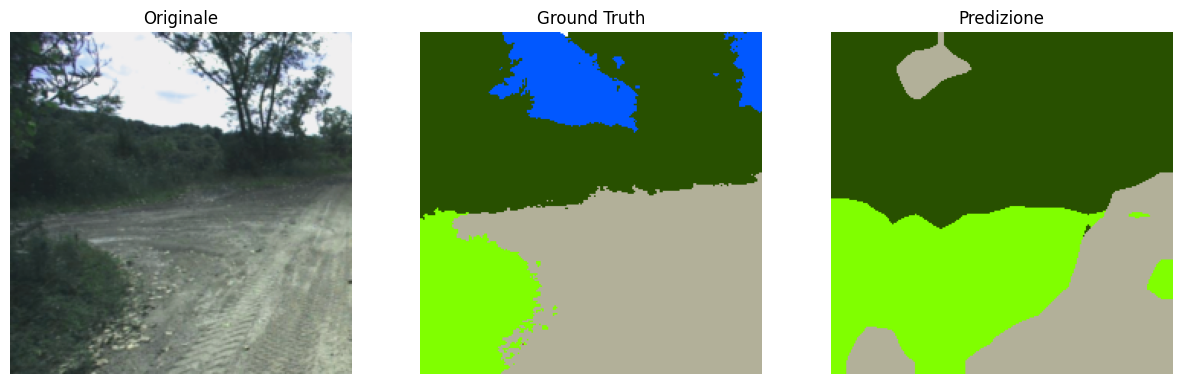

Campione 3:


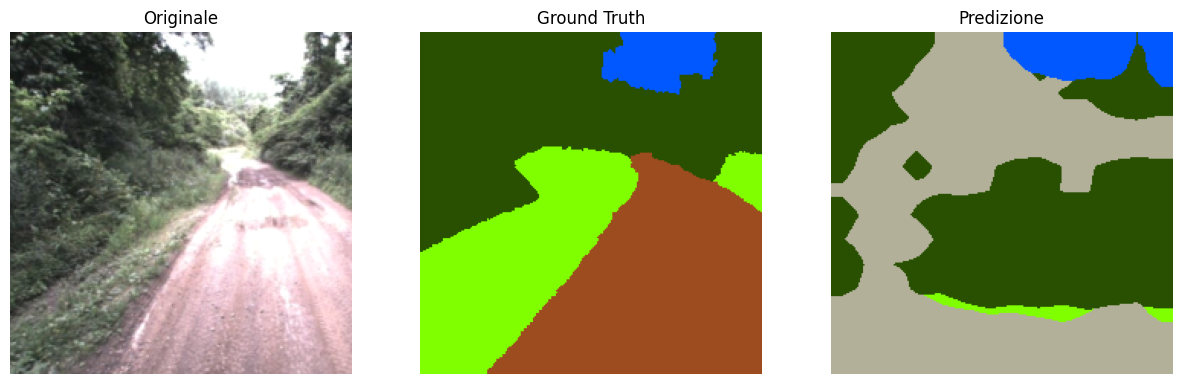

Campione 4:


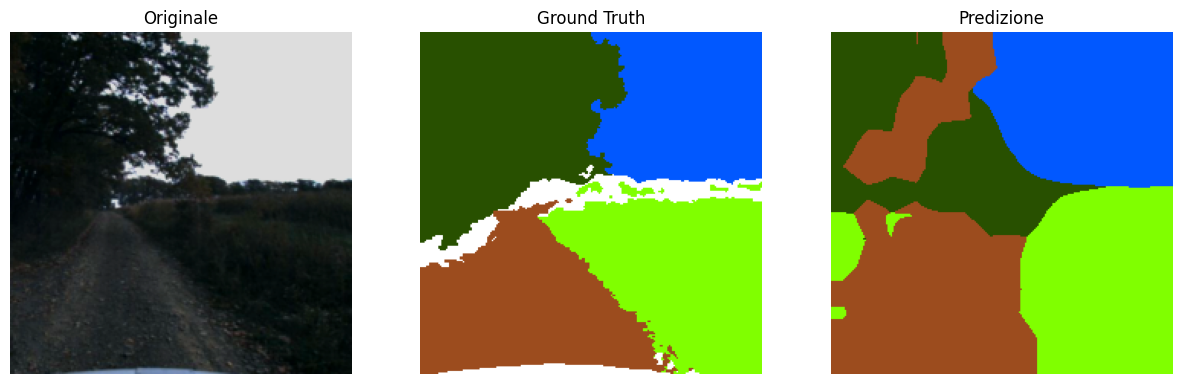

Campione 5:


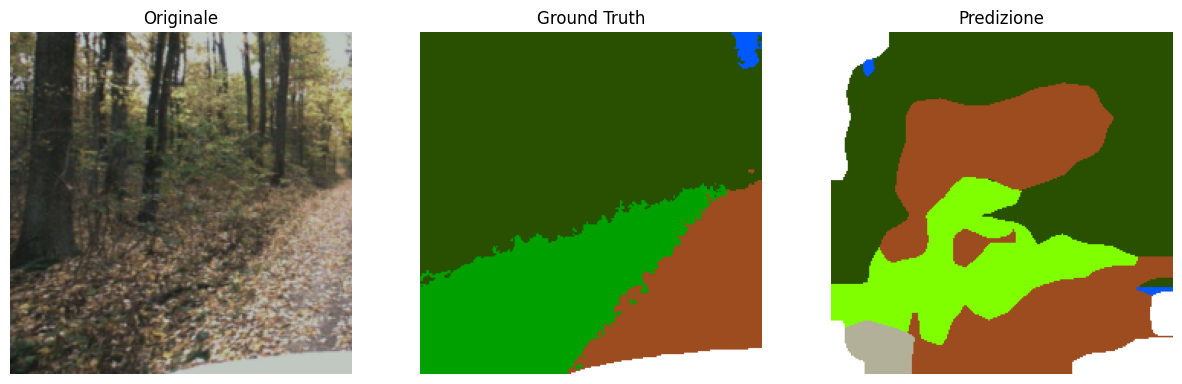

In [ ]:
# Test sul test set usando predict con metriche aggregate
from tqdm import tqdm
import numpy as np

@torch.no_grad()
def test_with_predict_aggregated(model, loader, device):
    model.eval()

    all_test_preds = []
    all_test_targets = []

    for imgs, masks in tqdm(loader, desc="Test"):
        bs = imgs.size(0)
        batch_preds = []

        for i in range(bs):
            # Immagine tensor in numpy per la funzione predict
            img_np = (imgs[i].cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)

            # Usa la funzione predict
            pred = predict(model, img_np)
            batch_preds.append(pred)

        # Predizioni in tensor
        batch_preds = torch.from_numpy(np.stack(batch_preds))

        all_test_preds.append(batch_preds)
        all_test_targets.append(masks)

    all_test_preds = torch.cat(all_test_preds)
    all_test_targets = torch.cat(all_test_targets)

    test_acc = compute_accuracy(all_test_preds, all_test_targets)

    test_iou = compute_iou_aggregated(all_test_preds, all_test_targets, num_classes=9)
    test_mean_iou = np.nanmean(test_iou)

    return test_acc, test_iou, test_mean_iou

# Esecuzione test
#test_acc, test_iou, test_mean_iou = test_with_predict_aggregated(model, test_loader, device)
test_acc, test_iou, test_mean_iou = test_with_predict_aggregated(model, val_loader, device)

print(f"\n=== RISULTATI TEST ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_mean_iou:.4f}")
print("Test IoU per classe:", np.round(test_iou, 4))

# Visualizza alcuni campioni random
print("\n=== VISUALIZZAZIONE CAMPIONI ===")
for i in range(5):
    idx = random.randrange(len(val_ds))
    img_t, mask_t = val_ds[idx]
    img_np = (img_t.permute(1,2,0).numpy() * 255).astype(np.uint8)
    pred_np = predict(model, img_np)
    print(f"Campione {i+1}:")
    visualize_pair(img_t, mask_t, pred_np)